In [ ]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics
from cosmosis.model import GPT

from dataset import TinyShakes

In [2]:
# explore the ds

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': 10,
            'n': 5}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  5
data.nbytes:  602664
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285]), 'y': tensor([22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,   502]), 'position': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
torch.Size([10]) torch.int64
torch.Size([10]) torch.int64
decoded tokens:  First Citizen: Before we proceed any further, hear
decoded y:   Citizen: Before we proceed any further, hear me


In [3]:
# example using prompt for inference

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'prompt': 'First Citizen: Before we proceed any further, hear '}

prompt = TinyShakes(**ds_param)
print(prompt[0])
print(prompt[0]['tokens'].shape)
# y wont be used in inference but is generated automatically 
# as part of the reuse of the getitem machinery
print(prompt[0]['y'].shape) 
print('decoded tokens: ', prompt.encoding.decode(prompt[0]['tokens'].tolist()))
print('decoded y: ', prompt.encoding.decode(prompt[0]['y'].tolist()))

len(self.ds_idx):  1
data.nbytes:  22
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,
          220]), 'y': tensor([22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,   220]), 'position': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}
torch.Size([11])
torch.Size([10])
decoded tokens:  First Citizen: Before we proceed any further, hear 
decoded y:   Citizen: Before we proceed any further, hear 


In [4]:
# pass a single example from dataset to model to loss function
# (batch, d_seq, d_model)

d_seq = 3 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 4 # dimension embedding vector
d_model = 4 # dimension model input

assert d_model == d_vec

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': d_seq,
            'n': 5}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))

model_param = {'device': 'cpu',
               'd_model': d_model, # matches embedding dimension
               'd_vocab': d_vocab, 
               'n_head': 2, 
               'num_layers': 2,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 

gpt = GPT(model_param)

data = ts[0]
out = gpt(data)
print('output: ', out, out.shape, out.dtype)

prompt_tokens = data['tokens']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['y']
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_embeddings = out.squeeze()
print('generated_embeddings: ', generated_embeddings, generated_embeddings.shape, generated_embeddings.dtype)
print('decoded generated tokens: ', prompt.encoding.decode(generated_embeddings.argmax(dim=-1).tolist()))

cel_func = CrossEntropyLoss()
loss = cel_func(out, target_tokens)
print('loss: ', loss)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  5
data.nbytes:  602664
CDataset created...
{'tokens': tensor([ 5962, 22307,    25]), 'y': tensor([22307,    25,  7413]), 'position': tensor([0, 1, 2])}
torch.Size([3]) torch.int64
torch.Size([3]) torch.int64
decoded tokens:  First Citizen:
decoded y:   Citizen: Before
applying _init_weights...
GPT model loaded...
number of model parameters:  201220
output:  tensor([[-0.0551, -0.0346, -0.0194,  ..., -0.0600,  0.0019, -0.0091],
        [ 0.0725,  0.0132,  0.0106,  ...,  0.0477, -0.0004, -0.0071],
        [-0.0308,  0.0183,  0.0575,  ...,  0.0051, -0.0430,  0.0288]],
       grad_fn=<MmBackward0>) torch.Size([3, 50304]) torch.float32
prompt_tokens:  tensor([ 5962, 22307,    25]) torch.Size([3]) torch.int64
target_tokens:  tensor([22307,    25,  7413]) torch.Size([3]) torch.int64
generated_embeddings:  tensor([[-0.0551, -0.0346, -0.0194,  ..., -0.0600,  0.0

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  301232
data.nbytes:  602664
CDataset created...
applying _init_weights...
GPT model loaded...
number of model parameters:  38634240
running model on gpu...

.....................

total elapsed time: 0:33:00.176100
epoch: 0
y_pred last 10:
 orth Marse
y last 10:
 th in holy
train loss: 0.14392451014630367, val loss: 0.1267038932275924
lr: 0.01

.....................

total elapsed time: 1:06:02.787138
epoch: 1
y_pred last 10:
 es Clar Ob
y last 10:
 ghter? now
train loss: 0.12475708958356871, val loss: 0.12408819235861301
lr: 0.01

.....................

total elapsed time: 1:38:27.242899
epoch: 2
y_pred last 10:
 uncils upl
y last 10:
 d with the
train loss: 0.12310422835839067, val loss: 0.12320109032537714
lr: 0.01

.....................

total elapsed time: 2:09:58.050037
epoch: 3
y_pred last 10:
 ting Power
y last 10:
 e that exh
train loss: 0.122

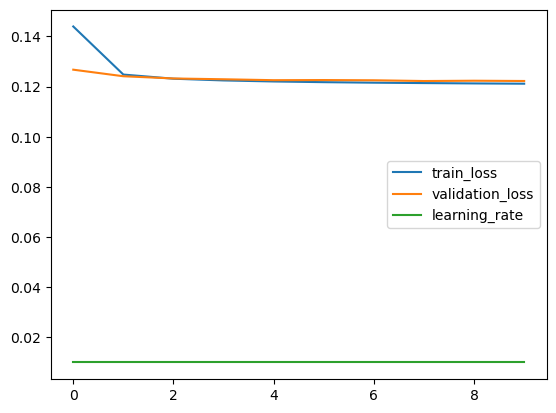

model state dict saved...
model embeddings saved...
model: tinyshakes768 saved...


In [5]:
# put all together in a learner
# (batch, d_seq, d_model)

d_seq = 100 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 768 # dimension embedding vector
d_model = 768 # dimension model input
assert d_model == d_vec

ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                            'y': [AsTensor()],
                            'position': [AsTensor()]},
            'd_seq': d_seq,
            #'n': 1000,
                           }}

model_param = {'d_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 12, 
               'num_layers': 12,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 1,
                 'log_plot': False,
                 'min_lr': .0025} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=32, epochs=10, gpu=True, save_model='tinyshakes768', 
              load_model=None, load_embed=False, target='y')

In [6]:
# inference
d_gen = 50 # dimension generate number of tokens
d_vocab = 50304 # dimension vocabulary
d_vec = 768 # dimension embedding vector
d_model = 768 # dimension model input
d_pos = 50 # dimension positional encoding d_pos >= max(len(prompt_tokens), d_gen)

assert d_model == d_vec


ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                                           'y': [AsTensor()],
                                           'position': [AsTensor()]},
                            'prompt': 'Farewell! God knows when we shall meet'}
           }

model_param = {
               'd_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 12, 
               'num_layers': 12,
               'd_gen': d_gen,
               'd_vec': d_vec,
               'temperature': 1000,
               'top_k': 2,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               #'y': (d_vocab, d_vec, None, True),
                               'position': (d_pos, d_vec, None, True)},
              } 
                                       
metrics_param = {'metric_name': 'transformer'}                        
             
opt_param = {}

crit_param = {}

sample_param = {}

sched_param = {}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=None, 
              Scheduler=None, 
              Criterion=None, # no criterion implies inference
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=1, epochs=5, gpu=True, 
              load_model='tinyshakes768.pth', load_embed=True, target=None)


len(self.ds_idx):  1
data.nbytes:  20
CDataset created...
applying _init_weights...
GPT model loaded...
number of model parameters:  38634240
model loaded from state_dict...
loading embedding weights...
running model on gpu...

.....................

total learning time: 0:00:01.393559
predictions:  [["ID!.  prevent not I are be again.  DUKE VINCENTIO: I'll warrant you, And, and, And therefore, And so much, and, And I will not, And, And, and his head,"]]
inference instance 2025-08-14 08:05:24.361340 complete and saved to csv...

.....................

total learning time: 0:00:01.633174
predictions:  [["ID!. 's not I are be again.  KING RICHARD III: I am not, And, And, and, And therefore I'll you, and, and the king, And, And, And, and, and,"]]
inference instance 2025-08-14 08:05:24.600955 complete and saved to csv...

.....................

total learning time: 0:00:01.867952
predictions:  [["ID!, 's not I are be again, I have done, And, And, And so much too.  BUCKINGHAM: I'll make a t